In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# <center>Determining the Correlation between Regime Changes and Media Coverage by Analyzing New York Times Headlines</center>
<center>Alex Matsoukas and Lila Smith</center>

## Introduction

The purpose of our project is to examine the New York Times coverage of various world conflicts in which the US had been involved with, either militarily or diplomatically. The inspiration for this focus comes from the role of the New York Times in the Iraq War in 2003, which includes publicizing faulty information about Weapons of Mass Destruction and swaying public perception in favor of US intervention.
For this project, we focused on the following three countries and time periods
- Chile (01/1960 to 01/1990)
- Libya (01/2008 to 01/2013)
- Bolivia (01/2018 to 01/2021)

for the purpose of answering "How does the quantity and quality of the New York Times media coverage vary around regime changes around the world?"

More specifically, this question can be broken down into three narrower fields of focus:
- How frequently does the New York Times mention a country per month in the time period surrounding regime changes?
- What words are most used in headlines about these countries during this time period?
- How do the headlines' sentiment correlate with specific regimes?

Our approach to providing an answer to these questions can be broken down into several stages including data collection, sentiment analysis, and effective communication of our findings. We utilized the New York Times Article Search API to obtain the data (in the form of article headlines), and Google Cloud's Natural Language API to analyze the text of the headlines. More detail on how exactly this was done will be provided in the Methodology section below. We also used Python's data visualization libraries such as Matplotlib, Numpy, and Wordcloud to create informative and effective graphics displaying the data and subsequent analysis.

## Methodology

### Collecting and Storing Data

The first step that we took towards answering our question was to obtain data from the [New York Times (NYT) Article Search API](https://developer.nytimes.com/docs/articlesearch-product/1/overview). The format of the requests is such that the base URI (`https://api.nytimes.com/svc/search/v2/articlesearch.json?q={query}&fq={filter}&api-key={yourkey}`) can be edited and altered to fit the desired search. We used this format as follows:

`https://api.nytimes.com/svc/search/v2/articlesearch.json?q={search_term}&fq=source:(\"The New York Times\")&begin_date={begin_date}&end_date={end_date}&"page={page}&api-key={api_key}`,

using the target country in place of `{search_term}` and the start and end dates in format YYYYMMDD in place of `{begin_date}` and `{end_date}`.

From the response provided by the API, we focused on the hits, which is the number of articles in which the search term is mentioned, and the headlines, on which we conducted sentiment anaylsis. Because the time span of our focus on each country spans at least 3 years, we grouped the hits and headlines by month when saving data.

An example of what the API returns for the country of Libya between the dates of January 1st and 31st, 20013 is shown in the code block below. If you would like to run this code block, add your API-key path below PATH_LILA and replace `with open(os.path.abspath(PATH_LILA), "r") as f:` with `with open(os.path.abspath(<YOUR_PATH>), "r") as f:`

In [1]:
import os
import pyjq
from obtaining import request_articles, get_hits

# Path to API Key not Stored in Repo
PATH_ALEX = "/home/softdes/Desktop/nytimes-api-key"
PATH_LILA = "api-keys/nytimes-api-key-lila"
#Add your API key path here before running

with open(os.path.abspath(PATH_LILA), "r") as f: #replace PATH_ALEX with your path variable
    api_key = f.readline().strip()
    
country_name = "Libya"
start_date = "20130101" # January 1st, 2013
end_date = "20130131" # January 31st, 2013

API_response = request_articles(country_name, start_date, end_date, api_key)
number_of_hits = get_hits(API_response)

headlines = pyjq.all('.response .docs[] .headline .main', API_response.json())

print(f"Between {start_date} and {end_date}, the term '{country_name}' appeared in {number_of_hits} articles. Ten headlines from this time period are:\n")
print(headlines)

Between 20130101 and 20130131, the term 'Libya' appeared in 84 articles. Ten headlines from this time period are:

['Italy Closes Consulate in Benghazi After New Attack', 'Lone Suspect Held in Benghazi Attack Is Freed in Tunisia', 'Clinton Testifies About Benghazi', 'Site of Kidnapping in Algeria', "Italy's Oil Leader Is Pursuing Its East African Bet", 'Mali’s Culture War: The Fate of the Timbuktu Manuscripts', 'French Troops Fight Alongside Mali Army Against Islamist Occupiers', 'The Early Word: On the Front', 'Why We Must Help Save Mali', 'A Lifelong Passion Is Now Put to Practice in The Hague']


The data collected from the NYT API is stored in a csv file, where each country gets its own data file. We utilized the Python Pandas library to organize the information into dataframes and save the dataframes to csv files. An example of what our stored data looks like is show below:

In [3]:
import pandas as pd
filepath = f"CountryData/{country_name}_data.csv"
dataframe = pd.read_csv(filepath)
dataframe.head()

,Country Name,MM-YYYY,Number of Hits,Sentiment Score (-1 to 1),Magnitude,Month's Headlines
0,Libya,01-2008,11,0.0,0.0,"['Rehabilitating Libya', 'A New France in the ..."
1,Libya,02-2008,11,-0.3,0.3,['Senior Qaeda Commander Is Killed by U.S. Mis...
2,Libya,03-2008,9,-0.1,0.1,['Papers Detail Complaints of Links to Treasur...
3,Libya,04-2008,15,0.0,0.0,['Libya Seeks Exemption for Its Debt to Victim...
4,Libya,05-2008,12,0.0,0.0,['Pakistani Nuclear Scientist Denies Selling S...


More details about the `Sentiment Score (-1 to 1)` and `Magnitude` columns will be provided below.

### Analyzing Headlines

After obtaining the raw data from NYT, we conducted sentiment analysis on the headlines using the [Google Cloud Natural Language API](https://cloud.google.com/natural-language). The sentiment analysis is done by posting plaintext headlines to the API, structured in the following way:

`body = {"document": {"type": "PLAIN_TEXT", "language": "en-us", "content": text}, "encodingType": "UTF32"}`,

where `text` is replaced by the headlines that we want to analyze. Before sending the monthly headlines to the API, the information was processed to remove the quotation marks and commas around/between the headlines so that purely headline text was analyzed.

An example of an analysis done by the Google Cloud API is shown below for the headlines for Libya in January 2008.

In [4]:
from processing import headline_list_to_string, request_sentiment
plaintext = headline_list_to_string(country_name, "200801")
analysis = request_sentiment(plaintext)
analysis.json()

{'documentSentiment': {'magnitude': 0, 'score': 0},
 'language': 'en-US',
 'sentences': [{'text': {'content': 'Rehabilitating Libya A New France in the New Middle East: Forget Glory Waving Goodbye to Hegemony Demand More From Libya After Veto, House Passes a Revised Military Policy Measure 3 Convicted Who Led Charity Tied to Militants Fiat King Holds Court in Rome Red Bulls Coach Heads South to Find Players Sarkozy Says Press Is Free to Ignore His Personal Life Unwilling New Frontier for Migrants: 3 Greek Isles Nuclear Scientists',
    'beginOffset': 0},
   'sentiment': {'magnitude': 0, 'score': 0}}]}

Based on this analysis, both the overall sentiment and the overall magnitude for this month are 0. The sentiment score ranges from -1 to 1, where -1 indicates that the text contained a very negative connotation and 1 indicates that the text contained a very positive connotation. In this case, a sentiment score of 0 implies that the tone of the headlines was, on average, neutral. The magnitude score indicates the strength of emotion conveyed in the text. The magnitude ranges from 0 to positive infinity, with a larger score indicating stronger emotionality (either positive or negative emotion); a high magnitude with a score of 0 indicates very strong mixed sentiments. We used the Pandas library again to read the existing csv data files and update the dataframes for each country.

### Answering the Questions

The data that we've collected on NYT media coverage for Chile, Libya, and Bolivia takes the form of hits, headlines, and sentiment analysis per month around the time period of a regime change and/or US military involvement in these countries. The number of hits can be used to gauge media attention, under the assumption that more hits means more media coverage by the NYT. We decided to visualize this data using a scatterplot of hits vs. time in order to get a sense of when each country was mentioned the most; our hypothesis that there should be spikes in hits around notable events can be verified with this plot. Because the data is already stored in an organized fashion, we used the Matplotlib library to create the scatterplot of the `Number of Hits` column vs. the `MM-YYYY` column from the csv file for each country.

To determine the kind of language that was most frequently used by the NYT to describe each country, we used Python's Wordcloud library to create a qualitative display of most common words. The more prominent words in the wordcloud should be a good indicator of how the NYT is describing the country around and during military/politcal conflict. We have the capability to create wordclouds for single, isolated months, which allows us to visualize headlines directly corresponding to large hit values.

In order to get a more quantitative understanding of the headline language, our third visualization of the data is a bubblechart that plots the sentiment score vs. time, with the size of the bubble corresponding to the number of hits. Once again, this data is plotted using Matplotlib's scatter function to plot the `Sentiment Score (-1 to 1)` column against the `MM-YYYY` column of each csv, controlling the size with the `Number of Hits`. This provides a comprehensive visual of both media attention and sentiment, allowing us to see big-picture trends that the wordcloud or the scatterplot can't do individually.

## Results

### Chile

The first country that we focused on was Chile, between 1960 and 1990. Our visualization of the data is shown below, as well as some analysis of key events.

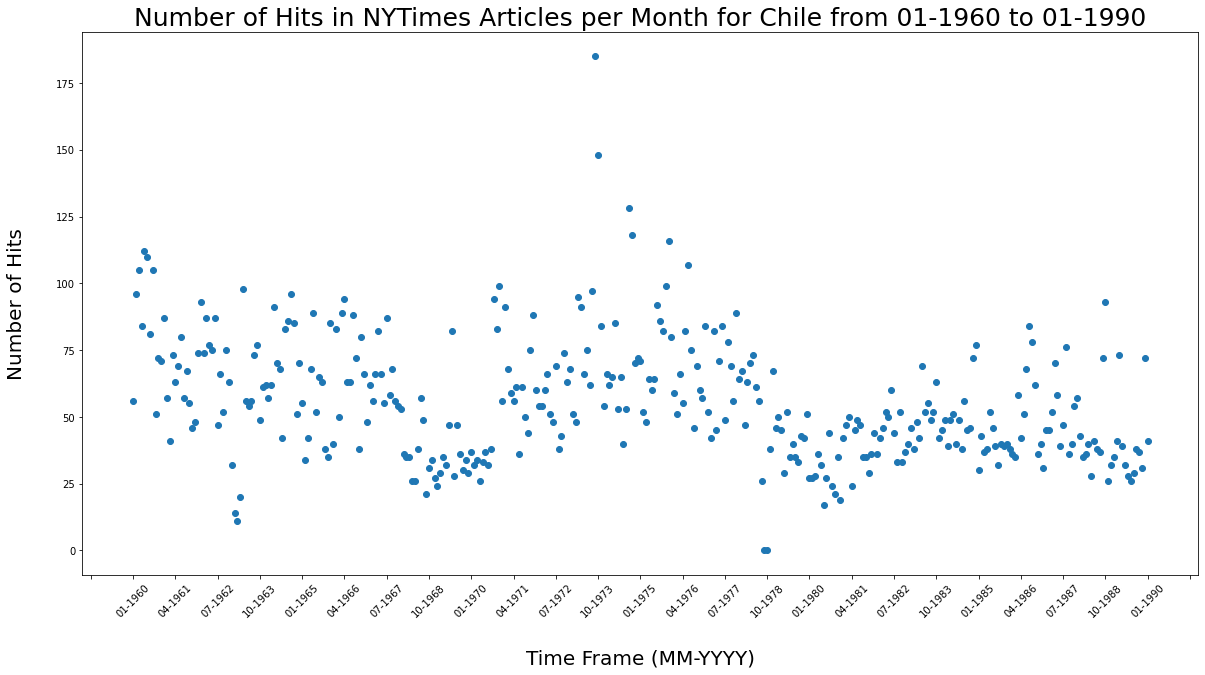

In [7]:
from visualization import create_scatter_plot

create_scatter_plot("Chile")

Based on this scatterplot, we can see one notable data point representing a month with significantly more hits than the rest. Because the data that we collected for Chile spans 30 years, we isolated a substet of that data just surrounding 09/1973 (the data point with over 175 hits). This scatterplot is shown below.

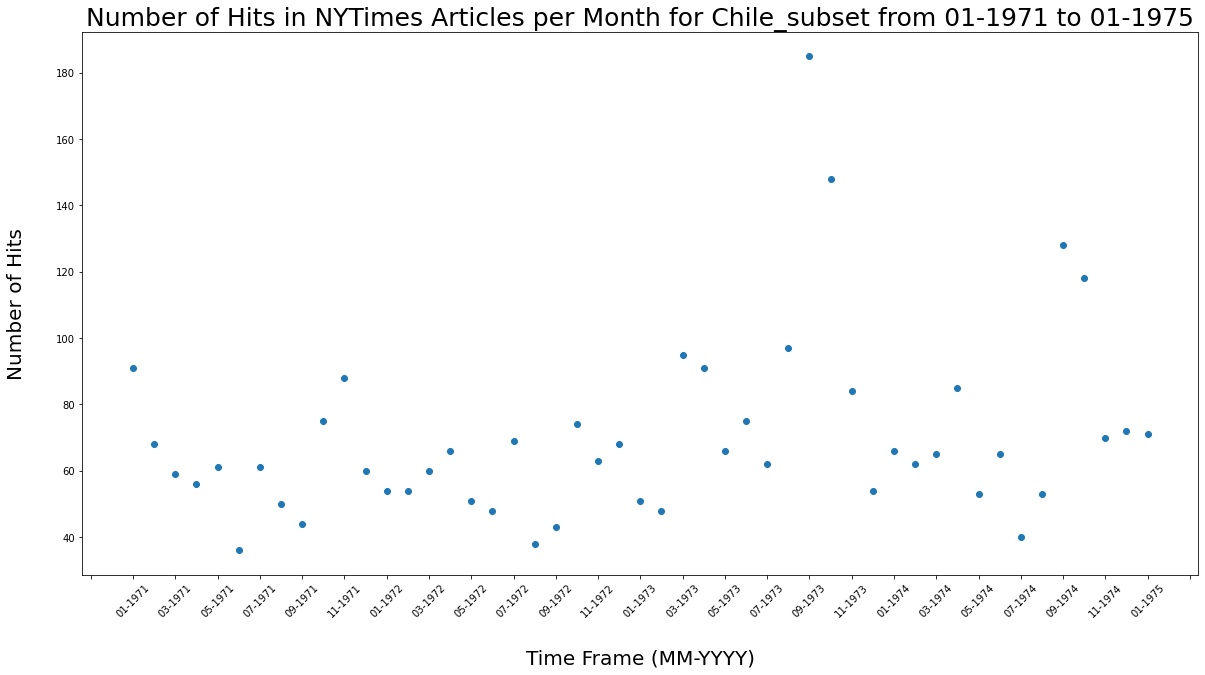

In [8]:
create_scatter_plot("Chile_subset")

Now we can more clearly see that the number of hits per month for Chile averages between 60 and 80. Some research shows that the Chilean coup d'étate took place on September 11, 1973, which explains the sudden increase in media attention during this time. Taking a look at the headlines for this month will further verify the cause of the NYT increased interest.

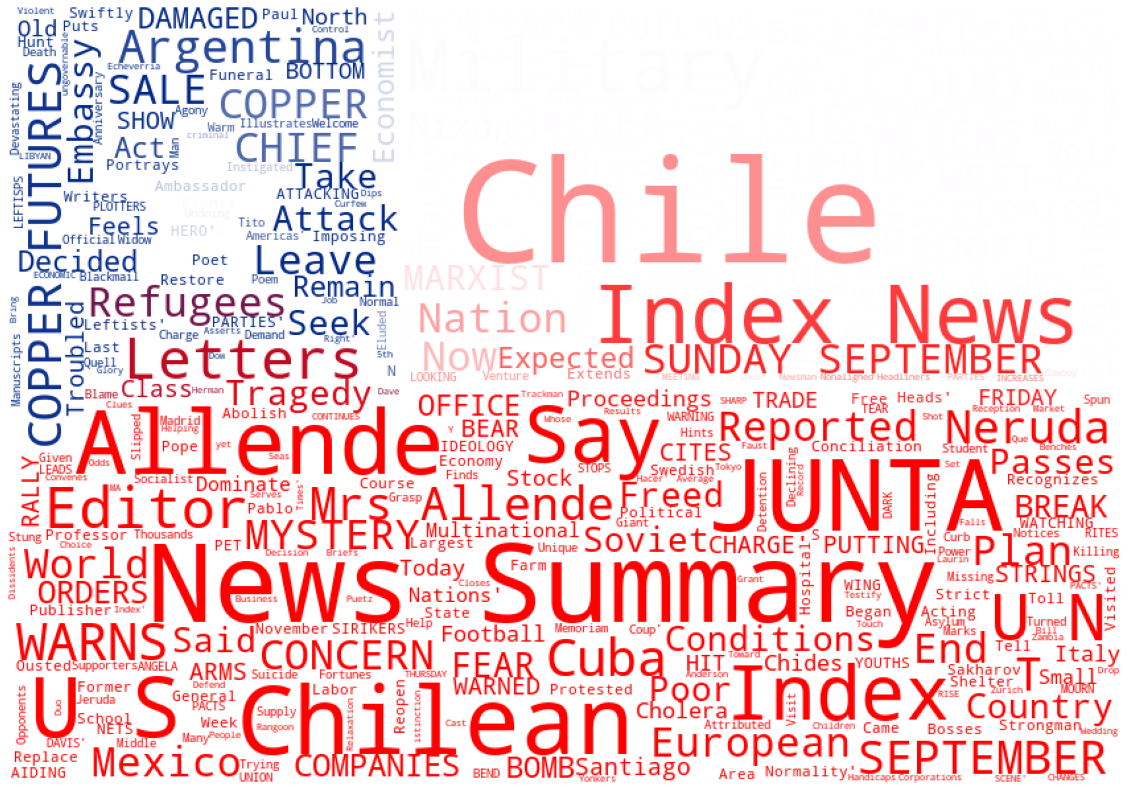

In [4]:
from visualization import create_word_cloud_one_month

create_word_cloud_one_month("Chile", "197309")

By looking at the largest words on this visual ("Military", "Junta", "Coup", "Allende"), we can infer that the topic of interest was indeed the military coup in which President Salvador Allende was killed. The bubble chart visual below demonstrates the way that the NYT sentiment towards Chile changed in the time period surrounding this event.

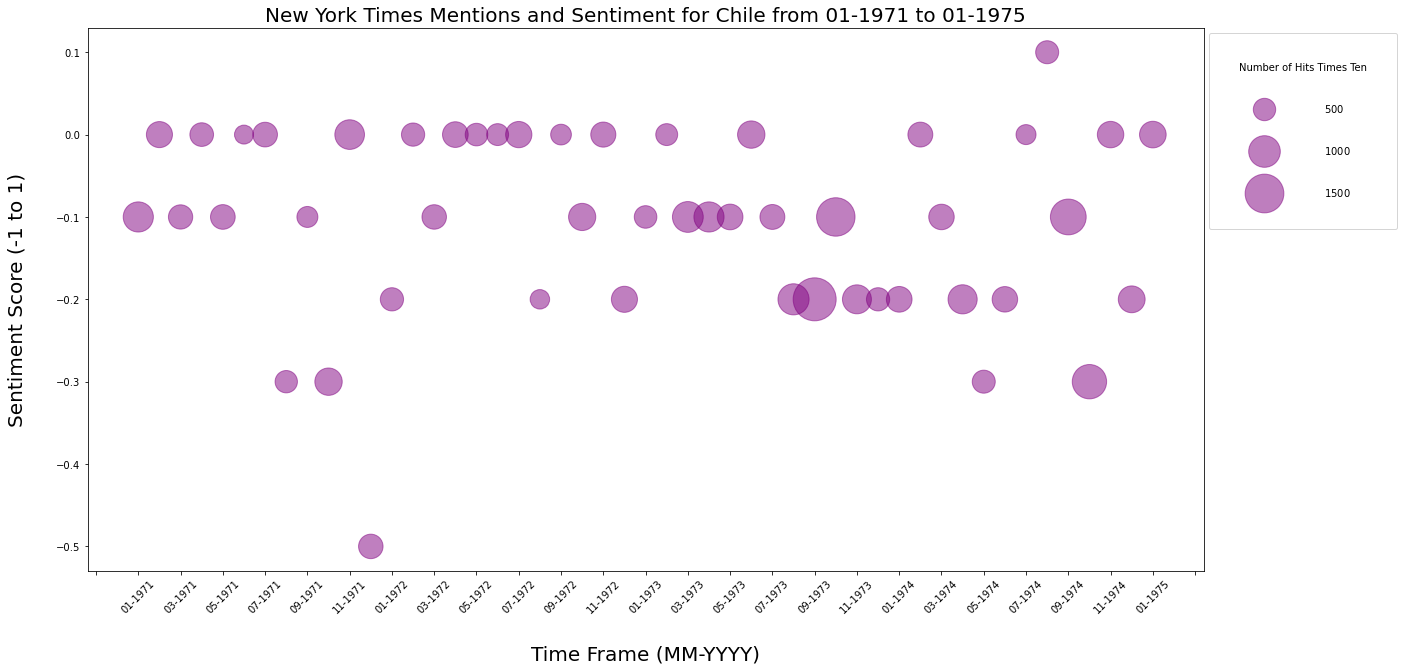

In [13]:
from visualization import create_bubble_chart

create_bubble_chart("Chile_subset")

The general seniment towards Chile appears to be negative or neutral, though the frequency of neutral sentiment decreases after the coup, after which the frequency of negative sentiment largely increases, and the values become more negative with a larger number of hits.

### Libya

The second country that we took a look at was Libya, between 2008 and 2013. Below is the scatterplot and a description of key events.

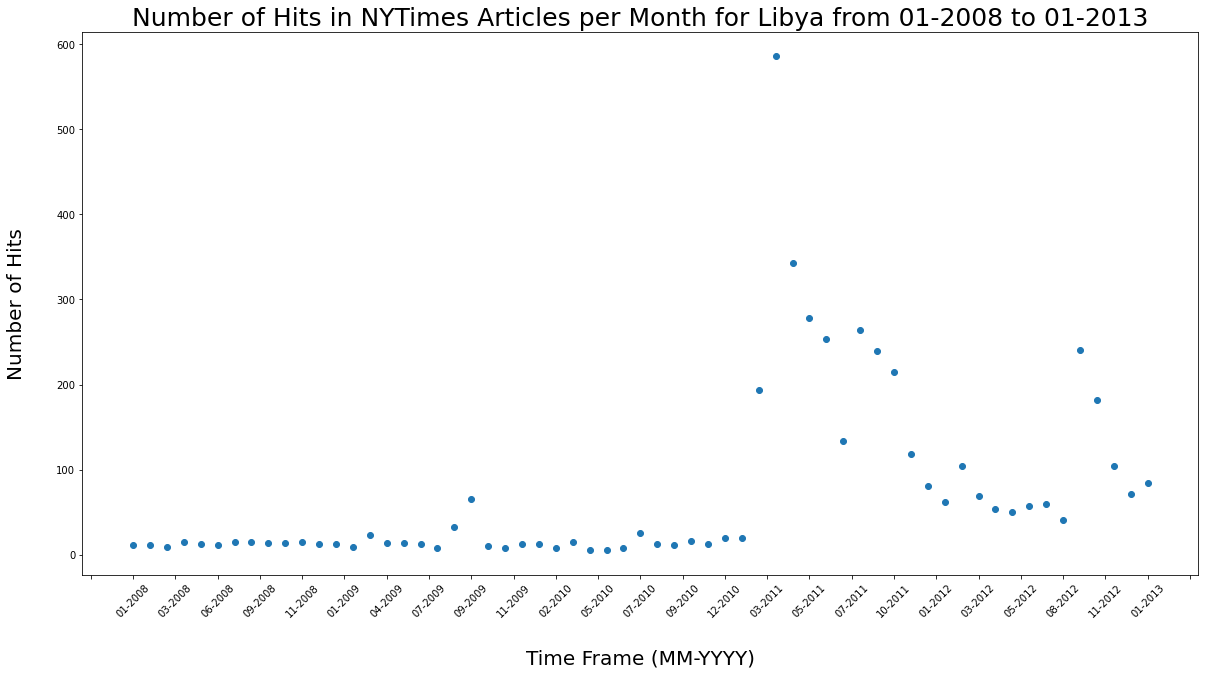

In [14]:
create_scatter_plot("Libya")

This plot looks much cleaner than that for Chile, mainly because the number of hits for Libya per month generally hovers close to 0. There appear to be 3 spikes in the number of hits: 09/2009, 03/2011, and 09/2012. In September 2009, Gaddafi spoke at the United Nations, in March 2011, NATO began military action in Libya, and in September 2012, the Benghazi attack occured. Once again, the number of hits over time demonstrates a strong correlation to major world events; below is a wordcloud for Libya for March 2011.

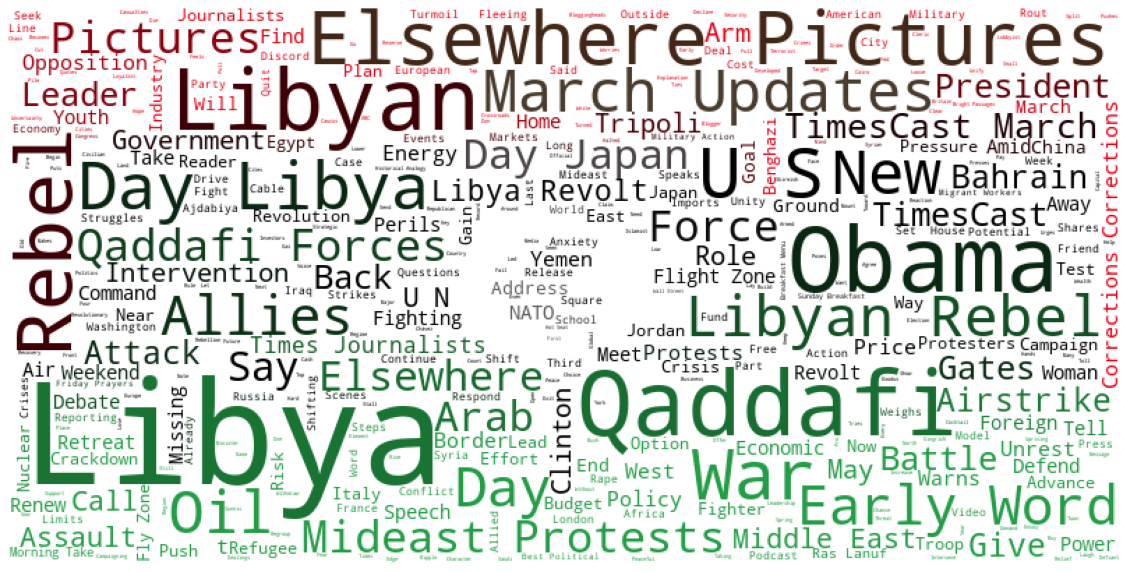

In [16]:
create_word_cloud_one_month("Libya", "201103")

Some of the most common terms in the wordcloud above are "Qaddafi", "Rebel", "Obama", and "Intervention." Sentiment analysis over time is shown below in the bubble chart for Libya during this time period.

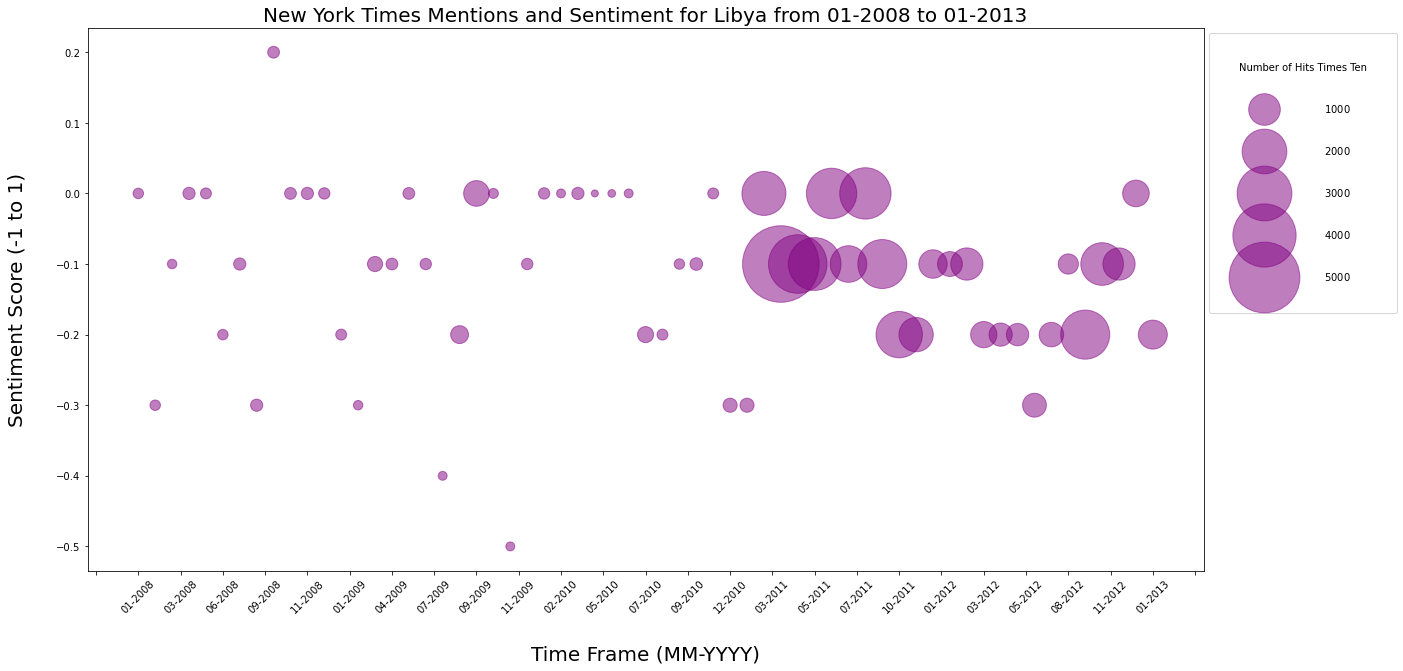

In [17]:
create_bubble_chart("Libya")

The same general trend from Chile's bubble chart is seen here: generally neutral or negative sentiment becomes more negative after the regime change. A notable exception is the point for August 2008, with a sentiment score of 0.2; Libya signed a claims agreement with the US during this month, and Libyan-Italian Friendship Day was created as well.

### Bolivia

Our third and final country of focus was Bolivia, from 2018 to 2021. The scatterplot is shown below:

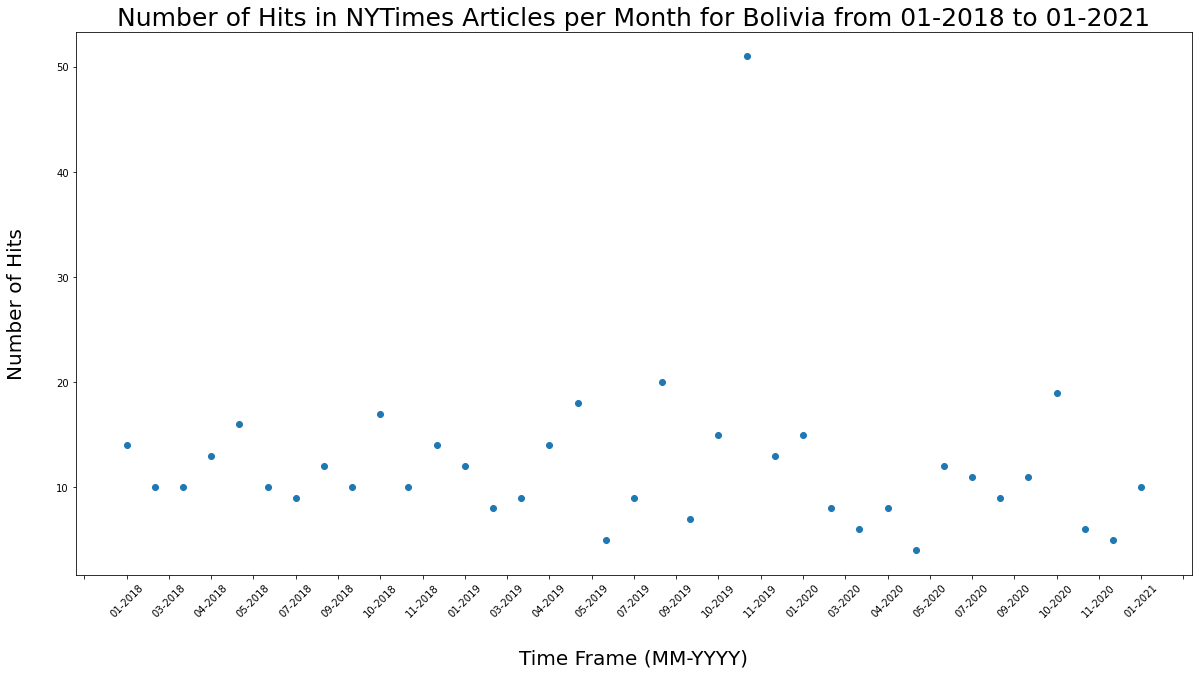

In [18]:
create_scatter_plot("Bolivia")

On average, the NYT mentioned Bolivia around 10 times per month, except for 11/2019. November 2019 coincides with the Bolvian political crisis, in which the Organization of American States (OAS) found issue with the electoral process following the October general election. Because the data that we collected for Bolvia is substantially smaller than that of the previous two countries, the wordcloud displayed below is composed of text from headlines over the entire time frame rather than just November 2019.

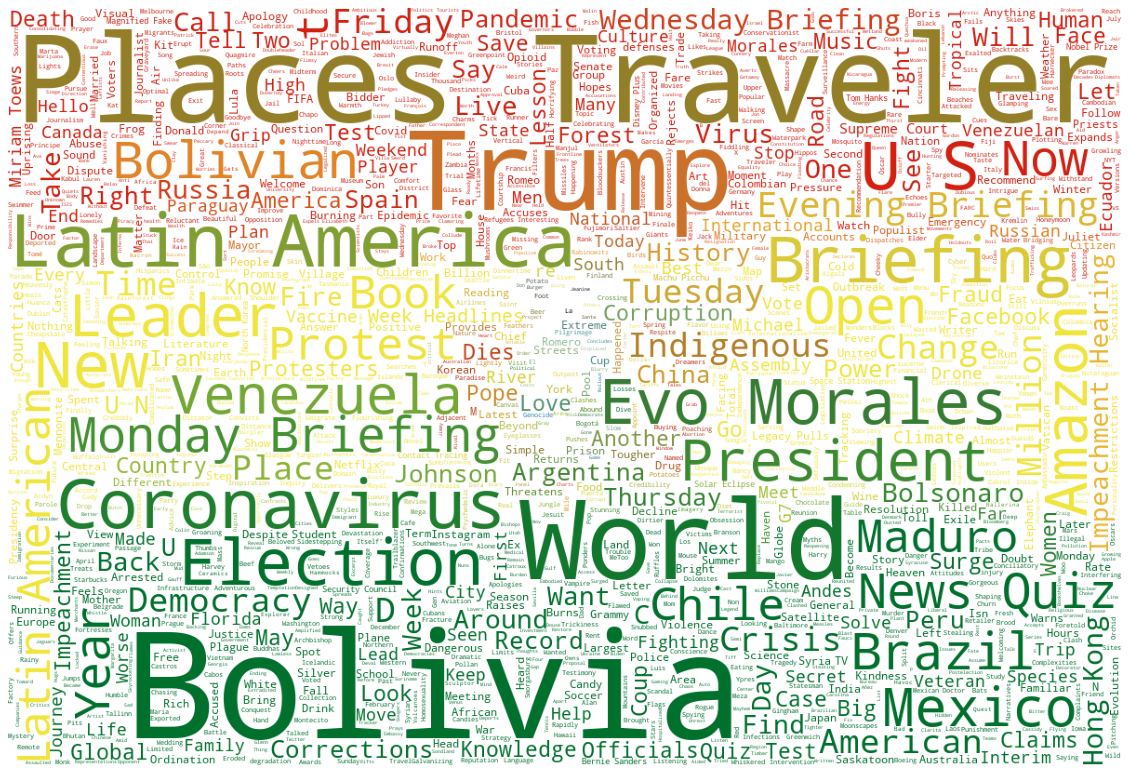

In [21]:
from visualization import create_word_cloud_all

create_word_cloud_all("Bolivia")

Looking at the word cloud, it appears that headlines irrelevant to the month of interest skew the results of the visualization; however, "Evo Morales" still appears to be one of the largest terms in the wordcloud, which makes sense considering that he was forced to resign as a result of the politcal crisis in 11/2019. Furthermore, the bubble chart can clear up the merging of headlines through a monthly sentiment analysis.

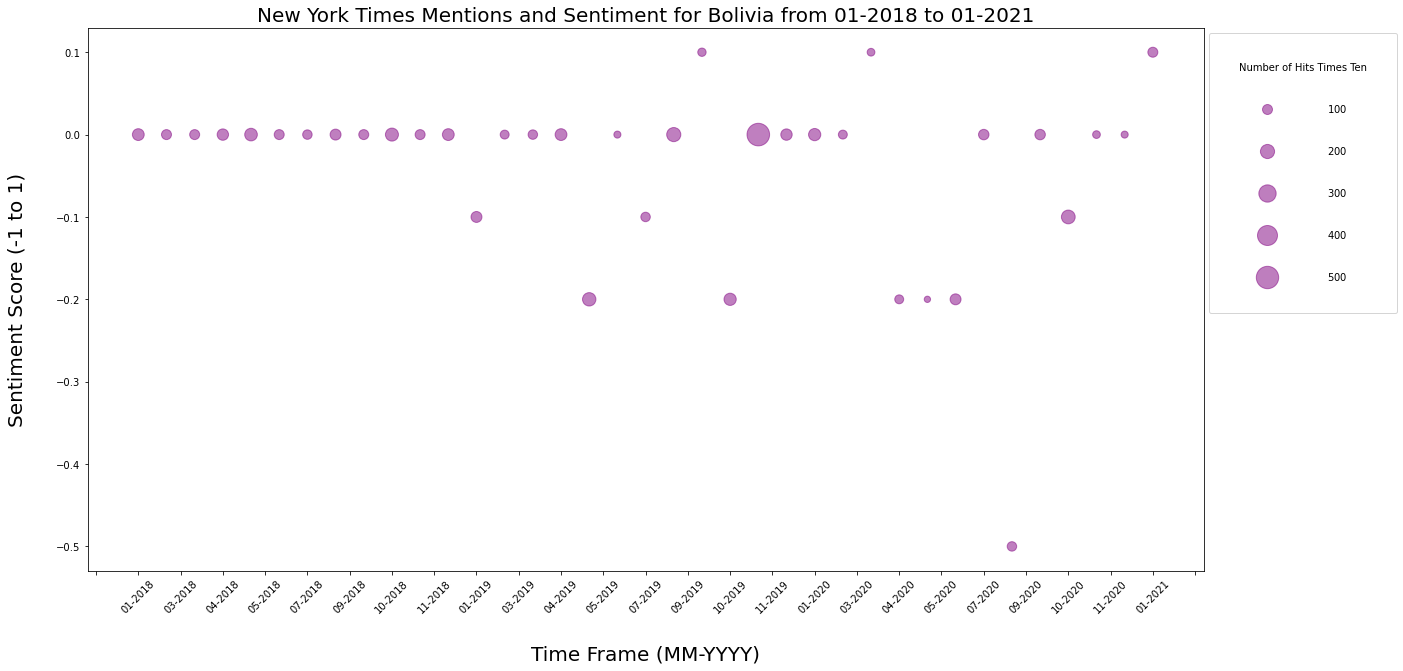

In [22]:
create_bubble_chart("Bolivia")

This bubble chart does not seem to follow the same trends as the previous two countries, mainly because the monthly headline sentiment doesn't appear to be affected by the events of November 2019; overall, the sentiment towards Bolvia is largely neutral, but has fluxuated between negative and positive in more recent months/years. During the month of August 2020, corresponding to the lowest sentiment, pro-Morales protests took place.

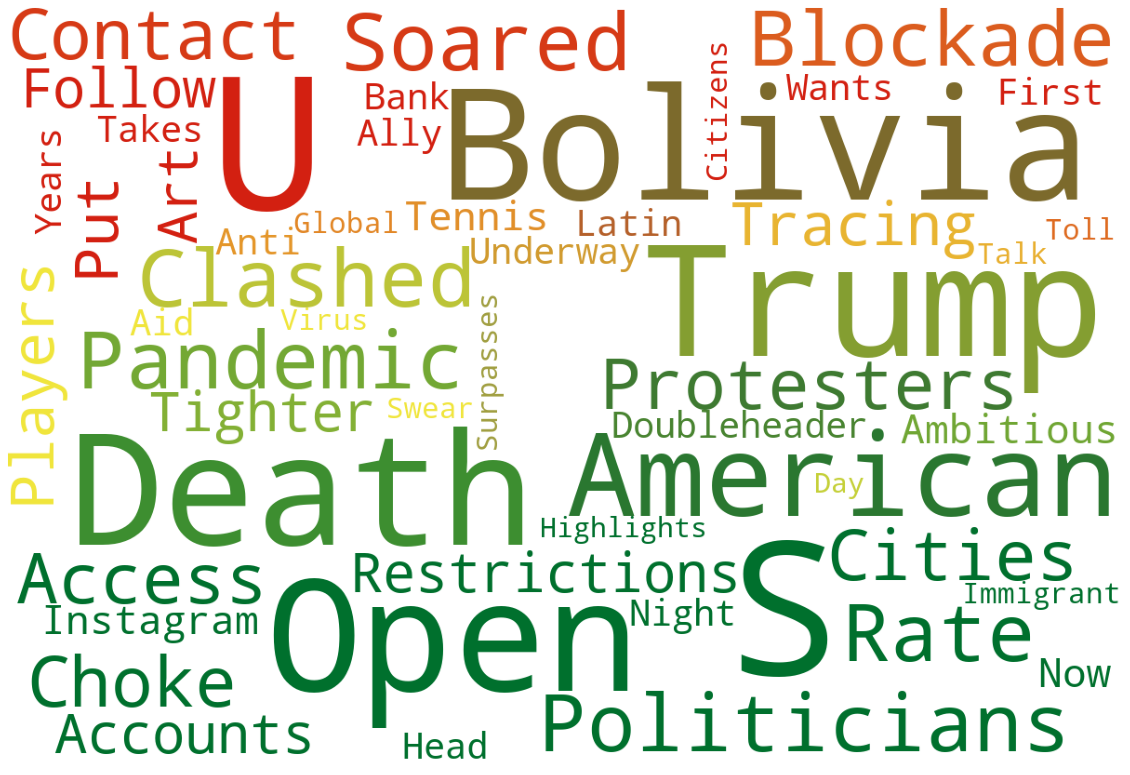

In [5]:
create_word_cloud_one_month("Bolivia","202008")

The word cloud helps confirm that many of these words relate to these protests: blockade, clashed, protesters, anti, etc. Some of them appear to be related to COVID-19 and tennis.

## Conclusion